In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

### Caricamento dataset

In [3]:
train_set=pd.read_csv("train.csv")
test_set=pd.read_csv("test.csv")

### Prima analisi del dataset

In [4]:
train_set.head()

,Winner,First_pokemon,Second_pokemon
0,421,568,421
1,748,124,748
2,648,648,129
3,16,16,571
4,115,115,582


In [5]:
test_set.head()

,Winner,First_pokemon,Second_pokemon
0,302,302,759
1,131,131,169
2,492,399,492
3,570,570,689
4,197,399,197


In [6]:
train_set.describe()

,Winner,First_pokemon,Second_pokemon
count,32000.000000,32000.000000,32000.000000
mean,408.765375,400.838094,403.410781
std,231.236790,229.994842,230.152860
min,1.000000,1.000000,1.000000
25%,206.000000,203.000000,208.000000
50%,422.000000,400.000000,403.000000
75%,606.000000,599.000000,603.000000
max,800.000000,800.000000,800.000000


In [7]:
test_set.describe()

,Winner,First_pokemon,Second_pokemon
count,8000.000000,8000.000000,8000.000000
mean,410.055875,402.314375,400.909875
std,231.311626,229.845478,230.307867
min,1.000000,1.000000,1.000000
25%,205.000000,205.000000,201.000000
50%,423.000000,401.000000,399.000000
75%,608.000000,600.000000,601.000000
max,800.000000,800.000000,800.000000


Essendo il dataset composto da semplici identificatori non si può ricavare nulla da questi dati.

In [8]:
print(f"Colonne del train_set: {list(train_set)}")

Colonne del train_set: ['Winner', 'First_pokemon', 'Second_pokemon']


In [9]:
train_set.nunique()

Winner            783
First_pokemon     784
Second_pokemon    784
dtype: int64

In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Winner          32000 non-null  int64
 1   First_pokemon   32000 non-null  int64
 2   Second_pokemon  32000 non-null  int64
dtypes: int64(3)
memory usage: 750.1 KB


Da degli ID ci si aspetta dei dati numerici e così avviene effettivamente

In [11]:
def get_null_elements_counter(train_set, test_set):
    print(f"Valori null nel train_set: \n{train_set.isna().sum()}")
    print("\n*-*-*-*-*-*-*-*\n")
    print(f"Valori null nel test_set: \n{test_set.isna().sum()}")

In [12]:
get_null_elements_counter(train_set, test_set)

Valori null nel train_set: 
Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64

*-*-*-*-*-*-*-*

Valori null nel test_set: 
Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64


Non sono presenti valori **null** nel dataset a noi consegnato. In ogni caso si procede a un'eliminazione di eventuali valori nulli nel dataset completo

In [13]:
train_set.dropna(inplace=True)
test_set.dropna(inplace=True)

In [14]:
get_null_elements_counter(train_set, test_set)

Valori null nel train_set: 
Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64

*-*-*-*-*-*-*-*

Valori null nel test_set: 
Winner            0
First_pokemon     0
Second_pokemon    0
dtype: int64


A questo punto dobbiamo andare a introdurre i dati relativi alle statistiche dei Pokemon. È fondamentale questa parte, altrimenti verrebbe un classificatore che non predice in base alle caratteristiche degli sfidanti ma in base ai loro ID.

In [15]:
pokemon_stats = pd.read_csv("pokemon.csv")

In [16]:
merged_train_set = train_set.merge(pokemon_stats, left_on='First_pokemon', right_on='#')
merged_test_set = test_set.merge(pokemon_stats, left_on='First_pokemon', right_on='#')
merged_train_set = merged_train_set.merge(pokemon_stats, left_on='Second_pokemon', right_on='#', suffixes=('_first', '_second'))
merged_test_set = merged_test_set.merge(pokemon_stats, left_on='Second_pokemon', right_on='#', suffixes=('_first', '_second'))
merged_train_set.head()

,Winner,First_pokemon,Second_pokemon,#_first,Name_first,Type 1_first,Type 2_first,HP_first,Attack_first,Defense_first,...,Type 1_second,Type 2_second,HP_second,Attack_second,Defense_second,Sp. Atk_second,Sp. Def_second,Speed_second,Generation_second,Legendary_second
0,421,568,421,568,Stoutland,Normal,NaN,85,110,90,...,Dragon,Psychic,80,130,100,160,120,110,3,True
1,421,100,421,100,Gastly,Ghost,Poison,30,35,30,...,Dragon,Psychic,80,130,100,160,120,110,3,True
2,421,247,421,247,Houndour,Dark,Fire,45,60,30,...,Dragon,Psychic,80,130,100,160,120,110,3,True
3,421,45,421,45,Jigglypuff,Normal,Fairy,115,45,20,...,Dragon,Psychic,80,130,100,160,120,110,3,True
4,421,259,421,259,Elekid,Electric,NaN,45,63,37,...,Dragon,Psychic,80,130,100,160,120,110,3,True


In [17]:
print(f"Dopo queste merge abbiamo mooooolte colonne. Andiamo a identificarle tutte")
print(f"{list(merged_train_set)}")

Dopo queste merge abbiamo mooooolte colonne. Andiamo a identificarle tutte
['Winner', 'First_pokemon', 'Second_pokemon', '#_first', 'Name_first', 'Type 1_first', 'Type 2_first', 'HP_first', 'Attack_first', 'Defense_first', 'Sp. Atk_first', 'Sp. Def_first', 'Speed_first', 'Generation_first', 'Legendary_first', '#_second', 'Name_second', 'Type 1_second', 'Type 2_second', 'HP_second', 'Attack_second', 'Defense_second', 'Sp. Atk_second', 'Sp. Def_second', 'Speed_second', 'Generation_second', 'Legendary_second']


Come si può vedere, sono presenti le colonne "$\#_{first/second}$" corrispondenti ai vari "First_pokemon" e "Second_pokemon" che vanno di fatto a duplicare il dato. Vengono quindi cancellate le colonne "$\#_{first/second}$". Inoltre si decide di rimuovere le feature "Name" in quanto non utile alla classificazione

### Prima eliminazione di colonne ritenute poco utili

Funzione per cancellare colonne

In [18]:
def drop_clumns(datasets:list, columns):
    for dataset in datasets:
        dataset.drop(labels=columns, inplace=True, axis=1)

In [19]:
to_drop = ["#_first", "#_second", 'Name_first', 'Name_second']
drop_clumns([merged_train_set, merged_test_set], to_drop)

In [20]:
print(f"columns: {list(merged_train_set)}")

columns: ['Winner', 'First_pokemon', 'Second_pokemon', 'Type 1_first', 'Type 2_first', 'HP_first', 'Attack_first', 'Defense_first', 'Sp. Atk_first', 'Sp. Def_first', 'Speed_first', 'Generation_first', 'Legendary_first', 'Type 1_second', 'Type 2_second', 'HP_second', 'Attack_second', 'Defense_second', 'Sp. Atk_second', 'Sp. Def_second', 'Speed_second', 'Generation_second', 'Legendary_second']


### Rimodulazione statistiche

Le statistiche (HP, Attack, ecc...) prese così non sono molto utili. Se messe in correlazione possono acquisire maggiore efficacia

In [21]:
def set_diff(datasets: list, columns: list):
    for dataset in datasets:
        for column in columns:
            dataset[f"{column}_diff"] = dataset[f"{column}_first"].astype(int) - dataset[f"{column}_second"].astype(int)

In [22]:
to_diff = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
set_diff([merged_test_set, merged_train_set], to_diff)
merged_train_set[["Attack_first", "Attack_second", "Attack_diff"]]
merged_train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_first,Type 2_first,HP_first,Attack_first,Defense_first,Sp. Atk_first,Sp. Def_first,...,Sp. Def_second,Speed_second,Generation_second,Legendary_second,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff
0,421,568,421,Normal,NaN,85,110,90,45,90,...,120,110,3,True,5,-20,-10,-115,-30,-30
1,421,100,421,Ghost,Poison,30,35,30,100,35,...,120,110,3,True,-50,-95,-70,-60,-85,-30
2,421,247,421,Dark,Fire,45,60,30,80,50,...,120,110,3,True,-35,-70,-70,-80,-70,-45
3,421,45,421,Normal,Fairy,115,45,20,45,25,...,120,110,3,True,35,-85,-80,-115,-95,-90
4,421,259,421,Electric,NaN,45,63,37,65,55,...,120,110,3,True,-35,-67,-63,-95,-65,-15


Ora andiamo a togliere le colonne relative alle statistiche dei singoli pokemon

In [23]:
to_drop = ["HP_first", "HP_second", "Attack_first", "Attack_second", "Defense_first", "Defense_second", "Sp. Atk_first", "Sp. Atk_second", "Sp. Def_first", "Sp. Def_second", "Speed_first", "Speed_second"]
drop_clumns([merged_train_set, merged_test_set], to_drop)
print(f"columns: {list(merged_train_set)}")

columns: ['Winner', 'First_pokemon', 'Second_pokemon', 'Type 1_first', 'Type 2_first', 'Generation_first', 'Legendary_first', 'Type 1_second', 'Type 2_second', 'Generation_second', 'Legendary_second', 'HP_diff', 'Attack_diff', 'Defense_diff', 'Sp. Atk_diff', 'Sp. Def_diff', 'Speed_diff']


In [24]:
merged_train_set.describe()

,Winner,First_pokemon,Second_pokemon,Generation_first,Generation_second,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,408.765375,400.838094,403.410781,3.323531,3.343594,-0.010250,-0.106531,0.057031,0.259531,-0.002656,-0.131969
std,231.236790,229.994842,230.152860,1.653937,1.654387,35.610282,46.131557,44.661559,46.286413,39.571935,41.430504
min,1.000000,1.000000,1.000000,1.000000,1.000000,-225.000000,-170.000000,-210.000000,-174.000000,-210.000000,-160.000000
25%,206.000000,203.000000,208.000000,2.000000,2.000000,-20.000000,-30.000000,-26.000000,-30.000000,-25.000000,-30.000000
50%,422.000000,400.000000,403.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,606.000000,599.000000,603.000000,5.000000,5.000000,20.000000,30.000000,27.000000,30.000000,25.000000,29.000000
max,800.000000,800.000000,800.000000,6.000000,6.000000,225.000000,175.000000,215.000000,179.000000,207.000000,165.000000


In [25]:
merged_train_set.nunique()

Winner               783
First_pokemon        784
Second_pokemon       784
Type 1_first          18
Type 2_first          18
Generation_first       6
Legendary_first        2
Type 1_second         18
Type 2_second         18
Generation_second      6
Legendary_second       2
HP_diff              303
Attack_diff          292
Defense_diff         349
Sp. Atk_diff         311
Sp. Def_diff         301
Speed_diff           267
dtype: int64

In [26]:
merged_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Winner             32000 non-null  int64 
 1   First_pokemon      32000 non-null  int64 
 2   Second_pokemon     32000 non-null  int64 
 3   Type 1_first       32000 non-null  object
 4   Type 2_first       16648 non-null  object
 5   Generation_first   32000 non-null  int64 
 6   Legendary_first    32000 non-null  bool  
 7   Type 1_second      32000 non-null  object
 8   Type 2_second      16709 non-null  object
 9   Generation_second  32000 non-null  int64 
 10  Legendary_second   32000 non-null  bool  
 11  HP_diff            32000 non-null  int64 
 12  Attack_diff        32000 non-null  int64 
 13  Defense_diff       32000 non-null  int64 
 14  Sp. Atk_diff       32000 non-null  int64 
 15  Sp. Def_diff       32000 non-null  int64 
 16  Speed_diff         32000 non-null  int64

In [27]:
get_null_elements_counter(merged_train_set, merged_test_set)

Valori null nel train_set: 
Winner                   0
First_pokemon            0
Second_pokemon           0
Type 1_first             0
Type 2_first         15352
Generation_first         0
Legendary_first          0
Type 1_second            0
Type 2_second        15291
Generation_second        0
Legendary_second         0
HP_diff                  0
Attack_diff              0
Defense_diff             0
Sp. Atk_diff             0
Sp. Def_diff             0
Speed_diff               0
dtype: int64

*-*-*-*-*-*-*-*

Valori null nel test_set: 
Winner                  0
First_pokemon           0
Second_pokemon          0
Type 1_first            0
Type 2_first         3912
Generation_first        0
Legendary_first         0
Type 1_second           0
Type 2_second        3892
Generation_second       0
Legendary_second        0
HP_diff                 0
Attack_diff             0
Defense_diff            0
Sp. Atk_diff            0
Sp. Def_diff            0
Speed_diff              0
dtype: int64


### Gestione "Type 2"

Non tutti i pokemon hanno l'attributo **Type 2**. Andare a cancellare la riga in cui è assente è alquanto deleterio (perderei tutte le informazioni su tali pokemon), le strategie possibili sono tre:

- inserire un tipo fasullo (avrei detto "folletto", ma Game Freak mi ha anticipato)
- eliminare completamente la feature
- duplicare il primo tipo, presente in tutti i mostriciattoli tascabili

Si sceglie di percorrere la terza via per non andare a introdurre del potenziale rumore o eliminare informazioni potenzialmente utili

In [28]:
merged_train_set["Type 2_first"] = merged_train_set.apply(lambda x: x['Type 1_first'] if pd.isnull(x['Type 2_first']) else x['Type 2_first'], axis=1)
merged_train_set["Type 2_second"] = merged_train_set.apply(lambda x: x['Type 1_second'] if pd.isnull(x['Type 2_second']) else x['Type 2_second'], axis=1)
merged_test_set["Type 2_first"] = merged_train_set.apply(lambda x: x['Type 1_first'] if pd.isnull(x['Type 2_first']) else x['Type 2_first'], axis=1)
merged_test_set["Type 2_second"] = merged_train_set.apply(lambda x: x['Type 1_second'] if pd.isnull(x['Type 2_second']) else x['Type 2_second'], axis=1)

In [29]:
get_null_elements_counter(merged_train_set, merged_test_set)

Valori null nel train_set: 
Winner               0
First_pokemon        0
Second_pokemon       0
Type 1_first         0
Type 2_first         0
Generation_first     0
Legendary_first      0
Type 1_second        0
Type 2_second        0
Generation_second    0
Legendary_second     0
HP_diff              0
Attack_diff          0
Defense_diff         0
Sp. Atk_diff         0
Sp. Def_diff         0
Speed_diff           0
dtype: int64

*-*-*-*-*-*-*-*

Valori null nel test_set: 
Winner               0
First_pokemon        0
Second_pokemon       0
Type 1_first         0
Type 2_first         0
Generation_first     0
Legendary_first      0
Type 1_second        0
Type 2_second        0
Generation_second    0
Legendary_second     0
HP_diff              0
Attack_diff          0
Defense_diff         0
Sp. Atk_diff         0
Sp. Def_diff         0
Speed_diff           0
dtype: int64


### Trasformazione "Winner" in 0/1

"Winner" indica l'ID del pokemon che vince. Per non portarci dietro quest'informazione si è scelto di assegnare a tale feature un valore binario che andrà ad indicare se il trionfante è il primo pokemon (0) o il secondo (1)

In [30]:
first_win = (merged_train_set.Winner == merged_train_set.First_pokemon)
merged_train_set.loc[first_win, 'Winner']='0'
second_win = (merged_train_set.Winner == merged_train_set.Second_pokemon)
merged_train_set.loc[second_win, 'Winner']='1'

first_win = (merged_test_set.Winner == merged_test_set.First_pokemon)
merged_test_set.loc[first_win, 'Winner']='0'
second_win = (merged_test_set.Winner == merged_test_set.Second_pokemon)
merged_test_set.loc[second_win, 'Winner']='1'

In [31]:
merged_train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_first,Type 2_first,Generation_first,Legendary_first,Type 1_second,Type 2_second,Generation_second,Legendary_second,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff
0,1,568,421,Normal,Normal,5,False,Dragon,Psychic,3,True,5,-20,-10,-115,-30,-30
1,1,100,421,Ghost,Poison,1,False,Dragon,Psychic,3,True,-50,-95,-70,-60,-85,-30
2,1,247,421,Dark,Fire,2,False,Dragon,Psychic,3,True,-35,-70,-70,-80,-70,-45
3,1,45,421,Normal,Fairy,1,False,Dragon,Psychic,3,True,35,-85,-80,-115,-95,-90
4,1,259,421,Electric,Electric,2,False,Dragon,Psychic,3,True,-35,-67,-63,-95,-65,-15


### Encoding e correlazione delle feature

In [32]:
def label_encoder(datasets):
    output_datasets = []
    encoder = LabelEncoder()
    for dataset in datasets:
        s = (dataset.dtypes == 'object')
        object_cols = list(s[s].index)
        label_dataset = dataset.copy()
        for col in object_cols:
            label_dataset[col] = encoder.fit_transform(label_dataset[col])
        output_datasets.append(label_dataset)
    return output_datasets

In [33]:
label_train, label_test = label_encoder([merged_train_set, merged_test_set])

In [34]:
label_train.head()

,Winner,First_pokemon,Second_pokemon,Type 1_first,Type 2_first,Generation_first,Legendary_first,Type 1_second,Type 2_second,Generation_second,Legendary_second,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff
0,1,568,421,12,12,5,False,2,14,3,True,5,-20,-10,-115,-30,-30
1,1,100,421,8,13,1,False,2,14,3,True,-50,-95,-70,-60,-85,-30
2,1,247,421,1,6,2,False,2,14,3,True,-35,-70,-70,-80,-70,-45
3,1,45,421,12,4,1,False,2,14,3,True,35,-85,-80,-115,-95,-90
4,1,259,421,3,3,2,False,2,14,3,True,-35,-67,-63,-95,-65,-15


<AxesSubplot:>

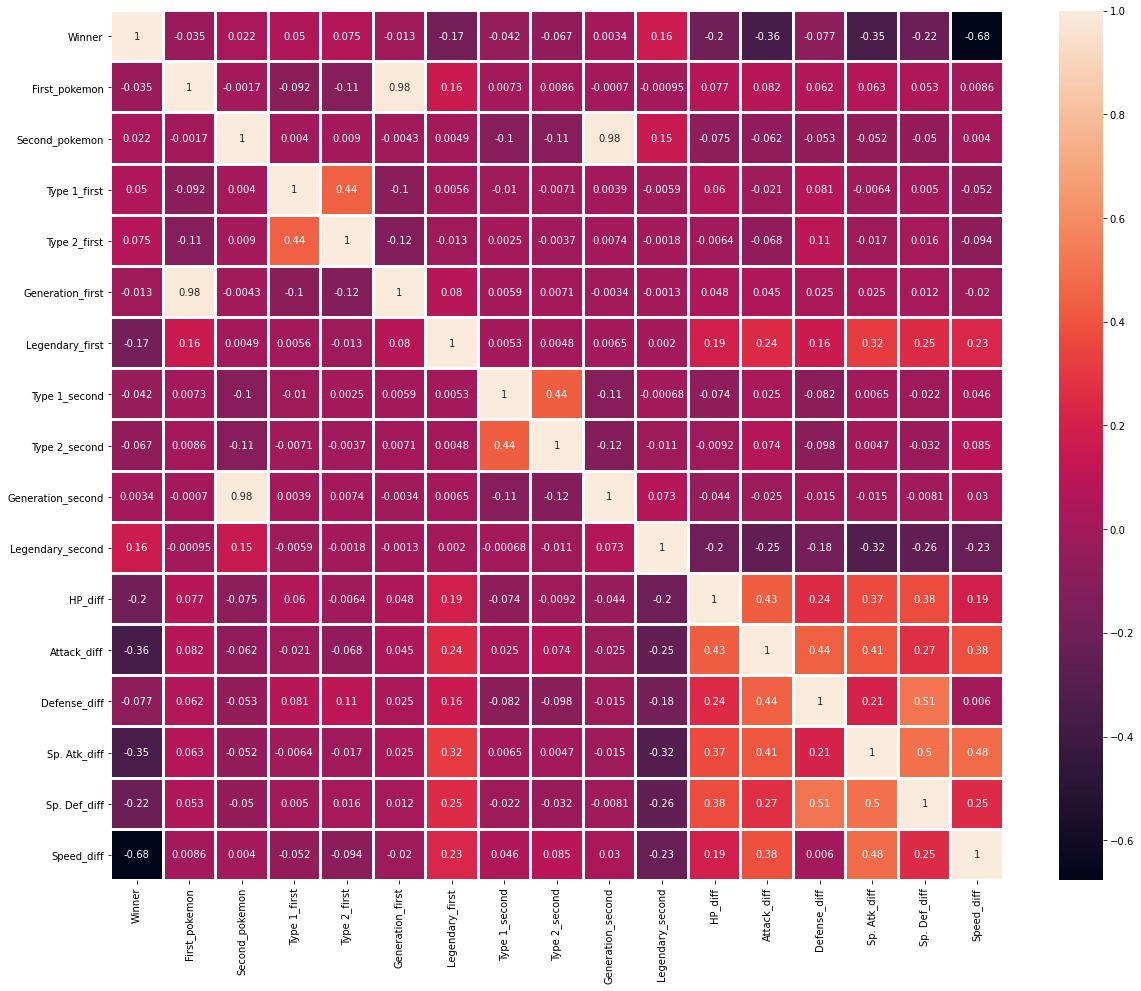

In [35]:
plt.figure(figsize=(20, 16))
correlation = label_train.corr()
sns.heatmap(correlation, annot = True, linewidth = 2)

Le feature, i cui valori associati a **Winner** si trovano attorno allo 0, sono quelli che hanno meno influenza. Si decide di porre la soglia a 0.18, andando a eliminare tutte le colonne il cui modulo è inferiore a tale valore. Queste sono:

- First_pokemon
- Second_pokemon
- Type 1_first
- Type 2_first
- Generation_first
- Type 1_second
- Type 2_second
- Generation_second
- Defense_diff
- Legendary_first
- Legendary_second

In [36]:
to_drop = ["First_pokemon", "Second_pokemon", "Type 1_first", "Type 2_first", "Generation_first", "Type 1_second", "Type 2_second", "Generation_second", "Defense_diff", "Legendary_first", "Legendary_second"]
drop_clumns([label_train, label_test], to_drop)

In [37]:
label_train.head()

,Winner,HP_diff,Attack_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff
0,1,5,-20,-115,-30,-30
1,1,-50,-95,-60,-85,-30
2,1,-35,-70,-80,-70,-45
3,1,35,-85,-115,-95,-90
4,1,-35,-67,-95,-65,-15


### Preparazione dati per l'apprendimento

In [38]:
train_raw = label_train.copy()
test_raw = label_test.copy()
y_train = train_raw["Winner"]
X_train = train_raw.drop(labels=["Winner"], axis=1)
y_test = test_raw["Winner"]
X_test = test_raw.drop(labels=["Winner"], axis=1)

In [39]:
X_train.head()

,HP_diff,Attack_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff
0,5,-20,-115,-30,-30
1,-50,-95,-60,-85,-30
2,-35,-70,-80,-70,-45
3,35,-85,-115,-95,-90
4,-35,-67,-95,-65,-15


In [40]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: Winner, dtype: int64

### Apprendimento

Vengono presi in considerazione due algoritmi di classificazione:

- K-Nearest Neighbors
- Decision Tree

Nel dettaglio, il primo algoritmo viene testato su più neighbors per vedere quale porta risultati migliori

In [41]:
best_results = {}

In [42]:
def get_train_test_accuracy(y_train, y_train_pred, y_test, y_test_pred):
    train_accuracy = round(accuracy_score(y_train, y_train_pred)*100, 2)
    test_accuracy = round(accuracy_score(y_test, y_test_pred)*100, 2)
    return train_accuracy, test_accuracy


In [43]:
best_configuration = (1, 0, 0)
best_KNC = None
for i in range(1, 15, 2):
    clf = KNeighborsClassifier(n_neighbors=i)

    clf.fit(X_train, y_train)
    

    y_train_pred=clf.predict(X_train)
    y_test_pred=clf.predict(X_test)

    train_accuracy, test_accuracy = get_train_test_accuracy(y_train, y_train_pred, y_test, y_test_pred)
    
    print(f"K-Neighbors con n_neighbors={i}")
    print("Train set accuracy: {:.2f}%".format(train_accuracy))
    print("Test set accuracy: {:.2f}%".format(test_accuracy))
    print("\n")
    if best_configuration[2] < test_accuracy or (best_configuration[2] == test_accuracy and best_configuration[1] < train_accuracy):
        best_configuration = (i, train_accuracy, test_accuracy)
        best_KNC = clf

print(f"La migliore configurazione di KNeighborsClassifier ha {best_configuration[0]} neighbors")
print(f"train_accuracy = {best_configuration[1]}%")
print(f"test_accuracy = {best_configuration[2]}%")
best_results['KNeighborsClassifier'] = (best_configuration[2], best_KNC)

K-Neighbors con n_neighbors=1
Train set accuracy: 100.00%
Test set accuracy: 88.39%


K-Neighbors con n_neighbors=3
Train set accuracy: 94.38%
Test set accuracy: 90.36%


K-Neighbors con n_neighbors=5
Train set accuracy: 93.54%
Test set accuracy: 91.15%


K-Neighbors con n_neighbors=7
Train set accuracy: 93.08%
Test set accuracy: 91.54%


K-Neighbors con n_neighbors=9
Train set accuracy: 92.84%
Test set accuracy: 91.59%


K-Neighbors con n_neighbors=11
Train set accuracy: 92.70%
Test set accuracy: 91.55%


K-Neighbors con n_neighbors=13
Train set accuracy: 92.66%
Test set accuracy: 91.52%


La migliore configurazione di KNeighborsClassifier ha 9 neighbors
train_accuracy = 92.84%
test_accuracy = 91.59%


In [44]:
dec_tree = DecisionTreeClassifier()

dec_tree.fit(X_train, y_train)

y_train_pred=dec_tree.predict(X_train)
y_test_pred=dec_tree.predict(X_test)

train_accuracy, test_accuracy = get_train_test_accuracy(y_train, y_train_pred, y_test, y_test_pred)

print(f"Decision Tree Classifier")
print(f"train_accuracy = {train_accuracy}%")
print(f"test_accuracy = {test_accuracy}%")
print("")

best_results['DecisionTreeClassifier'] = (test_accuracy, dec_tree)

Decision Tree Classifier
train_accuracy = 100.0%
test_accuracy = 90.69%



In [45]:
best_results

{'KNeighborsClassifier': (91.59, KNeighborsClassifier(n_neighbors=9)),
 'DecisionTreeClassifier': (90.69, DecisionTreeClassifier())}

In [46]:
best_classifier = ("", 0)
for classifier in best_results:
    accuracy = best_results[classifier][0]
    if accuracy > best_classifier[1]:
        best_classifier = (classifier, accuracy)
print(f"Il miglior classificatore è {best_classifier[0]} con un'accuracy di {best_classifier[1]}%")

Il miglior classificatore è KNeighborsClassifier con un'accuracy di 91.59%


KNeighborsClassifier


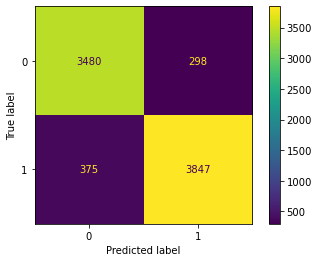

In [47]:
print("KNeighborsClassifier")
plot_confusion_matrix(best_results['KNeighborsClassifier'][1], X_test, y_test)

DecisionTreeClassifier


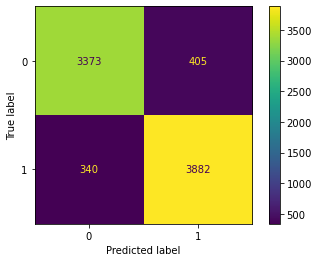

In [48]:
print("DecisionTreeClassifier")
plot_confusion_matrix(best_results['DecisionTreeClassifier'][1], X_test, y_test)

Le due matrici di confusione risultano molto simili. Le differenze sono nel fatto che KNN ha molti meno FP e qualche FN in più. Nel dataset a nostra disposizione i due algoritmi performano comunque in modo simile, con il primo che ha prestazioni di poco superiori al secondo (la differenza è di 0.1 punto percentuale di accuracy). Ne consegue che il classificatore scelto sia **KNeighborsClassifier**

# Risultato finale

In [49]:
print(f"Classificatore: {best_results['KNeighborsClassifier'][1]}")
print(f"Accuracy: {best_results['KNeighborsClassifier'][0]}%")
# print(best_results["KNeighborsClassifier"])

Classificatore: KNeighborsClassifier(n_neighbors=9)
Accuracy: 91.59%


KNeighborsClassifier


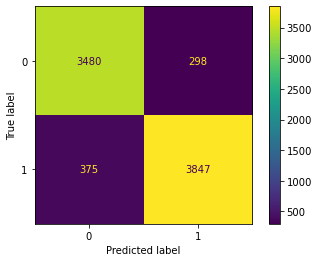

In [50]:
print("KNeighborsClassifier")
plot_confusion_matrix(best_results['KNeighborsClassifier'][1], X_test, y_test)